## Данные

Данные -  https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps
Необходимо предсказать рейтинг приложения 

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [144]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [166]:
data = pd.read_csv('/content/gdrive/MyDrive/AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


Поделим фичи на числовые и категориальные


In [167]:
num_cols = [
    'size_bytes',
    'price',
    'rating_count_tot',
    'rating_count_ver',
    'sup_devices.num',
    'ipadSc_urls.num',
    'lang.num',
    'cont_rating',
]

cat_cols = [
    'currency',
    'prime_genre'
]

target_col = 'user_rating'

cols = num_cols + cat_cols + [target_col]

In [168]:
data = data[cols]
data['cont_rating'] = data['cont_rating'].str.slice(0, -1).astype(int)
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,currency,prime_genre,user_rating
0,100788224,3.99,21292,26,38,5,10,4,USD,Games,4.0
1,158578688,0.00,161065,26,37,5,23,4,USD,Productivity,4.0
2,100524032,0.00,188583,2822,37,5,3,4,USD,Weather,3.5
3,128512000,0.00,262241,649,37,5,9,12,USD,Shopping,4.0
4,92774400,0.00,985920,5320,37,5,45,4,USD,Reference,4.5


In [169]:
data.isna().mean()

size_bytes          0.0
price               0.0
rating_count_tot    0.0
rating_count_ver    0.0
sup_devices.num     0.0
ipadSc_urls.num     0.0
lang.num            0.0
cont_rating         0.0
currency            0.0
prime_genre         0.0
user_rating         0.0
dtype: float64

In [170]:
#распределение категориальных фичей
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

currency DISTRIBUTION
USD    7197
Name: currency, dtype: int64

prime_genre DISTRIBUTION
Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: prime_genre, dtype: int64



In [171]:
#в колонке currency только одно значение, можно колонку убрать
data = data.drop(columns=['currency'])
cat_cols.remove('currency')

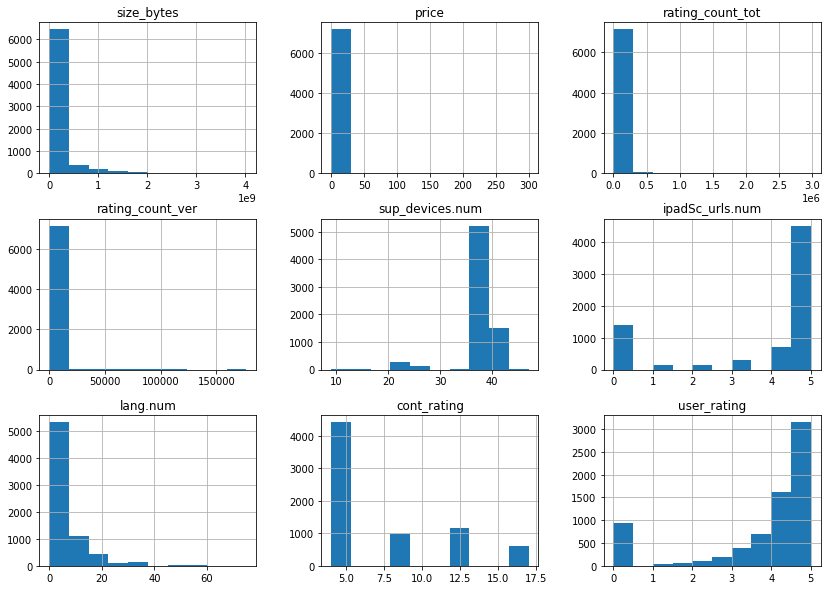

In [172]:
#распредление величин
data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))
None

А теперь посмотрим на корреляции между фичами

In [173]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,user_rating
size_bytes,1.00,0.18,0.00,0.01,-0.12,0.15,0.00,0.14,0.07
price,0.18,1.00,-0.04,-0.02,-0.12,0.07,-0.01,-0.03,0.05
rating_count_tot,0.00,-0.04,1.00,0.16,0.01,0.02,0.14,0.01,0.08
rating_count_ver,0.01,-0.02,0.16,1.00,0.04,0.02,0.01,0.00,0.07
sup_devices.num,-0.12,-0.12,0.01,0.04,1.00,-0.04,-0.04,0.02,-0.04
ipadSc_urls.num,0.15,0.07,0.02,0.02,-0.04,1.00,0.09,-0.11,0.27
lang.num,0.00,-0.01,0.14,0.01,-0.04,0.09,1.00,-0.07,0.17
cont_rating,0.14,-0.03,0.01,0.00,0.02,-0.11,-0.07,1.00,-0.10
user_rating,0.07,0.05,0.08,0.07,-0.04,0.27,0.17,-0.10,1.00


In [174]:
# Добавим категориальную фичу, которая говорит, бесплатное приложение или нет
data['is_free'] = data['price'] == 0
cat_cols.append('is_free')
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre,user_rating,is_free
0,100788224,3.99,21292,26,38,5,10,4,Games,4.0,False
1,158578688,0.00,161065,26,37,5,23,4,Productivity,4.0,True
2,100524032,0.00,188583,2822,37,5,3,4,Weather,3.5,True
3,128512000,0.00,262241,649,37,5,9,12,Shopping,4.0,True
4,92774400,0.00,985920,5320,37,5,45,4,Reference,4.5,True


#### One-hot-encoding
Самый простой способ закодировать категориальные фичи - one hot encoding. Представьте, что у нас есть категориальная фича prime_genre с возможными значениями 
> ['Games', 'Entertainment', 'Education', 'Photo & Video']

мы можем создать 4 новые бинарные фичи для каждого из столбцов

> 'Entertaiment' -> [0, 1, 0, 0]

В pandas очень удобно использовать get_dummies для one-hot-encoding

In [175]:
a = pd.DataFrame.from_dict({'categorical': ['a', 'b', 'a', 'c']})
a

,categorical
0,a
1,b
2,a
3,c


In [176]:
pd.get_dummies(a)

,categorical_a,categorical_b,categorical_c
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1


In [177]:
# Задание: добавьте в датафрейм колонки для всех категориальных фичей и обновите список категориальных фичей
def get_one_hot(data):
  for column in cat_cols:
      tempdf = pd.get_dummies(data[column], prefix=column)
      data = pd.merge(
          left=data,
          right=tempdf,
          left_index=True,
          right_index=True,
      )
      cat_cols.remove(column)
  return data

In [178]:
df = get_one_hot(data)

In [179]:
diff = df.columns.difference(data.columns)
print(diff)
for d in diff:
  cat_cols.append(d)
data = df

Index(['prime_genre_Book', 'prime_genre_Business', 'prime_genre_Catalogs',
       'prime_genre_Education', 'prime_genre_Entertainment',
       'prime_genre_Finance', 'prime_genre_Food & Drink', 'prime_genre_Games',
       'prime_genre_Health & Fitness', 'prime_genre_Lifestyle',
       'prime_genre_Medical', 'prime_genre_Music', 'prime_genre_Navigation',
       'prime_genre_News', 'prime_genre_Photo & Video',
       'prime_genre_Productivity', 'prime_genre_Reference',
       'prime_genre_Shopping', 'prime_genre_Social Networking',
       'prime_genre_Sports', 'prime_genre_Travel', 'prime_genre_Utilities',
       'prime_genre_Weather'],
      dtype='object')


In [180]:
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre,user_rating,is_free,prime_genre_Book,prime_genre_Business,prime_genre_Catalogs,prime_genre_Education,prime_genre_Entertainment,prime_genre_Finance,prime_genre_Food & Drink,prime_genre_Games,prime_genre_Health & Fitness,prime_genre_Lifestyle,prime_genre_Medical,prime_genre_Music,prime_genre_Navigation,prime_genre_News,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,100788224,3.99,21292,26,38,5,10,4,Games,4.0,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,158578688,0.00,161065,26,37,5,23,4,Productivity,4.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,100524032,0.00,188583,2822,37,5,3,4,Weather,3.5,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,128512000,0.00,262241,649,37,5,9,12,Shopping,4.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,92774400,0.00,985920,5320,37,5,45,4,Reference,4.5,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Масштабирование признаков

Как мы говорили в лекции часто необходимо привести все признаки к одному масштабу. Для этого в sklearn есть специальный Transformer -- StandardScaler и MinMaxScaler.

StandardScaler во время .fit() для каждого признака $x_i$ считает среднее $\mu_i$ и стандартное отклонение $\sigma_i$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$


MinMaxScaler во время .fit() для каждого признака $x_i$ считает минимум $x_{i, \text{min}}$ и максимум $x_{i, \text{max}}$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - x_{i, \text{min}}}{x_{i, \text{max}} - x_{i, \text{min}}}$$

In [181]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
pca.fit(data[num_cols + cat_cols])
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X = pca.transform(data[num_cols + cat_cols])

## Разделение на train/test



In [182]:
from sklearn.model_selection import train_test_split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=0.2)

## Обучение


In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

Поговорим про метрики. Метрика это, так же как и функция потерь, какая-то функция, показывающая насколько хорошо работает наша модель. Например, любой лосс можно назвать метрикой. Но не любую метрику можно назвать лоссом: лосс это именно то число, которое мы уменьшаем в процессе обучения модели + для лосса всегда верно, что чем он меньше, тем лучше. Метрики нужны как раз для того, чтобы оценивать работу алгоритма с помощью числа, которое он не учился напрямую минимизировать.

Для классификации наиболее простой метрикой будет являться точность или accuracy (доля совпавших предсказаний и настоящих классов). Она никогда не используется внутри лоссов, потому что нет эффективного алгоритма, который бы позволил ее обучать модели с такой функцией потерь.

В данном случае у нас задача регрессии, поэтому мы используем метрику MSE

In [185]:
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

In [186]:
# Используем обычную линейную регрессию, минимизирующую сумму квадратов ошибки
lr = LinearRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_test), y_test)

R^2: -5.853057819605394
MSE: 2.0091761708352256


In [187]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_test), y_test)

R^2: -1.1760290654863903
MSE: 1.8540069444444447


## Cross Validation


Получим из кроссвалидации метрики

In [188]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

In [189]:
cross_validate(LinearRegression(), X, data[target_col], cv=5, 
               scoring={'r2_score': make_scorer(r2_score), 
                        'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.01637268, 0.02002048, 0.02222633, 0.02291083, 0.01780629]),
 'score_time': array([0.00344634, 0.00154328, 0.00149298, 0.00152731, 0.00144362]),
 'test_mean_squared_error': array([1.66639417, 1.4875399 , 1.94036265, 2.81726398, 2.93168231]),
 'test_r2_score': array([-0.83125285,  0.06624317,  0.11575732,  0.11001206,  0.07117408])}

In [190]:
cross_validate(KNeighborsRegressor(), X, data[target_col], cv=5, 
               scoring={'r2_score': make_scorer(r2_score, ), 
                        'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.04076934, 0.02963018, 0.03438401, 0.03128266, 0.03443599]),
 'score_time': array([0.21612263, 0.3522017 , 0.27363968, 0.26250196, 0.26149273]),
 'test_mean_squared_error': array([1.43509028, 1.604125  , 2.1318763 , 2.56031967, 2.88879778]),
 'test_r2_score': array([-0.57706574, -0.00693949,  0.02848263,  0.19118207,  0.08476091])}

## GridSearchCV
А еще с помощью кросс валидации можно искать гиперпараметры.

In [191]:
from sklearn.model_selection import GridSearchCV

In [192]:
gbr_grid_search = GridSearchCV(KNeighborsRegressor(), 
                               [{'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 15]}],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_neighbors=1 ...................................................
[CV] ...................... n_neighbors=1, score=-0.419, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.434, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.455, total=   0.2s
[CV] n_neighbors=1 ...................................................
[CV] ...................... n_neighbors=1, score=-0.490, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.414, total=   0.2s
[CV] n_neighbors=2 ...................................................
[CV] ...................... n_neighbors=2, score=-0.092, total=   0.2s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.071, total=   0.2s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.108, total=   0.3s
[CV] n_neighbors=2 ...................................................
[CV] ...................... n_neighbors=2, score=-0.132, total=   0.2s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.059, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.035, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.023, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] ...................... n_neighbors=3, score=-0.011, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.016, total=   0.2s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.056, total=   0.2s
[CV] n_neighbors=4 ...................................................
[CV] ....................... n_neighbors=4, score=0.084, total=   0.2s
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.8s finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 15]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [193]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'n_neighbors': 15}
0.15914225273327534
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')


In [ ]:
# Задание: обучите несколько других моделей и получите лучшие скоры

In [197]:
#1 модель - XGBRegressor
from xgboost import XGBRegressor

param = {
        'n_estimators': [100],
        'max_depth': [5,7,9,11,13,15,17,20],
        'random_state': [24, 48,2020],
        'min_child_weight': [1, 300],
    }

gbr_grid_search = GridSearchCV(XGBRegressor(), 
                               [param],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=24 
[10:20:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=24, score=0.832, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=24 
[10:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=24, score=0.823, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=24 
[10:20:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=24, score=0.849, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=24 
[10:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=24, score=0.802, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=24 
[10:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=24, score=0.850, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=48 
[10:20:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=48, score=0.832, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=48 
[10:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.4s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=48, score=0.823, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=48 
[10:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.1s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=48, score=0.849, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=48 
[10:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.8s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=48, score=0.802, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=48 
[10:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.5s remaining:    0.0s


[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=48, score=0.850, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020 
[10:20:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020, score=0.832, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020 
[10:20:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020, score=0.823, total=   0.7s
[CV] max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020 
[10:20:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_child_weight=1, n_estimators=100, random_state=2020, score=0.849

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 7, 9, 11, 13, 15, 17, 20],
                          'min_chi

In [198]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'random_state': 24}
0.8311751830713788
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=24,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [201]:
#2 модель - Lasso
from sklearn import linear_model

param1 = {
        'alpha' : [0.1, 0.3, 0.5, 1],
        'max_iter': [1000],
        'random_state': [24, 48,2020],
        'tol': [0.0001, 0.001],
    }

gbr_grid_search = GridSearchCV(linear_model.Lasso(), 
                               [param1],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.0001 ...........
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.0001, score=0.081, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.0001 ...........
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.0001, score=0.081, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.0001 ...........
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.0001, score=0.099, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.0001 ...........
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.0001, score=0.087, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.0001 ...........
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.0001, score=0.094, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=24, tol=0.001 ............
[CV]  alpha=0.1, max_iter=1000, random_state=24, tol=0.001, score=0.081,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s



[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.0001, score=0.099, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.0001 .........
[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.0001, score=0.087, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.0001 .........
[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.0001, score=0.094, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.001 ..........
[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.001, score=0.081, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.001 ..........
[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.001, score=0.081, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.001 ..........
[CV]  alpha=0.1, max_iter=1000, random_state=2020, tol=0.001, score=0.099, total=   0.0s
[CV] alpha=0.1, max_iter=1000, random_state=2020, tol=0.001 ..........
[CV]  alpha=0.1, max_iter=1000, rand

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.1, 0.3, 0.5, 1], 'max_iter': [1000],
                          'random_state': [24, 48, 2020],
                          'tol': [0.0001, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [202]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'alpha': 0.1, 'max_iter': 1000, 'random_state': 24, 'tol': 0.0001}
0.08848039971927812
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=24,
      selection='cyclic', tol=0.0001, warm_start=False)


In [203]:
#3 модель - ElasticNet
from sklearn.linear_model import ElasticNet

param2 = {
        'alpha' : [0.1, 0.3, 0.5, 1],
        'max_iter': [1000],
        'random_state': [24, 48,2020],
        'tol': [0.0001, 0.001],
        'l1_ratio' : [0.001, 0.1, 0.5, 0.6, 1]
    }

gbr_grid_search = GridSearchCV(ElasticNet(), 
                               [param2],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001, score=0.103, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001, score=0.137, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001, score=0.125, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001, score=0.148, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.001, score=0.137, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.001, score=0.125, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.001, score=0.148, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001, score=0.103, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.0001, score=0.137, total=   0.0s
[

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.001, score=0.125, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=48, tol=0.001, score=0.148, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001, score=0.103, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001, score=0.137, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001 
[CV]  alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=2020, tol=0.0001, score=0.12

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    7.6s finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.1, 0.3, 0.5, 1],
                          'l1_ratio': [0.001, 0.1, 0.5, 0.6, 1],
                          'max_iter': [1000], 'random_state': [24, 48, 2020],
                          'tol': [0.0001, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [204]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'alpha': 0.1, 'l1_ratio': 0.001, 'max_iter': 1000, 'random_state': 24, 'tol': 0.001}
0.12692609127261983
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.001,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=24, selection='cyclic', tol=0.001, warm_start=False)


In [210]:
#4 модель - Bayesian ridg


param3 = {
        'n_iter' : [1000],
        'alpha_1' : [0.1, 0.001, 0.0001, 1],
        'alpha_2' : [0.1, 0.001, 0.0001, 1],
        'lambda_1' : [0.1, 0.001, 0.0001, 1],
        'tol': [0.0001, 0.001],
        'lambda_2' : [0.1, 0.001, 0.0001, 1]
    }

gbr_grid_search = GridSearchCV(linear_model.BayesianRidge(), 
                               [param3],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001, score=0.101, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001, score=0.136, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001, score=0.124, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s


[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001, score=0.101, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001, score=0.136, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001, score=0.124, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.1, n_iter=1000, tol=0.001, score=0.150, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.001, n_iter=1000, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.1, lambda_2=0.001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, al

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


Выходные данные были обрезаны до нескольких последних строк (5000).
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001, score=0.121, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001, score=0.102, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001, score=0.137, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001, score=0.125, total=   0.0s
[CV] alpha_1=0.1, alpha_2=0.1, lambda_1=0.001, lambda_2=0.0001, n_iter=1000, tol=0.0001 
[CV]  alpha_1=0.1, 

[Parallel(n_jobs=1)]: Done 2560 out of 2560 | elapsed:   57.2s finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                     alpha_init=None, compute_score=False,
                                     copy_X=True, fit_intercept=True,
                                     lambda_1=1e-06, lambda_2=1e-06,
                                     lambda_init=None, n_iter=300,
                                     normalize=False, tol=0.001,
                                     verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha_1': [0.1, 0.001, 0.0001, 1],
                          'alpha_2': [0.1, 0.001, 0.0001, 1],
                          'lambda_1': [0.1, 0.001, 0.0001, 1],
                          'lambda_2': [0.1, 0.001, 0.0001, 1], 'n_iter': [1000],
                          'tol': [0.0001, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, ver

In [211]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'alpha_1': 0.0001, 'alpha_2': 1, 'lambda_1': 1, 'lambda_2': 0.0001, 'n_iter': 1000, 'tol': 0.0001}
0.1268062305145458
BayesianRidge(alpha_1=0.0001, alpha_2=1, alpha_init=None, compute_score=False,
              copy_X=True, fit_intercept=True, lambda_1=1, lambda_2=0.0001,
              lambda_init=None, n_iter=1000, normalize=False, tol=0.0001,
              verbose=False)
